In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

# State

In [2]:
import operator
from dataclasses import dataclass, field
from typing_extensions import Annotated

@dataclass(kw_only=True)
class SummaryState:
    research_topic: str = field(default=None) # Report topic     
    search_query: str = field(default=None) # Search query
    web_research_results: Annotated[list, operator.add] = field(default_factory=list) 
    sources_gathered: Annotated[list, operator.add] = field(default_factory=list) 
    research_loop_count: int = field(default=0) # Research loop count
    running_summary: str = field(default=None) # Final report

@dataclass(kw_only=True)
class SummaryStateInput:
    research_topic: str = field(default=None) # Report topic     

@dataclass(kw_only=True)
class SummaryStateOutput:
    running_summary: str = field(default=None) # Final report

# Config

In [3]:
import os
from enum import Enum
from pydantic import BaseModel, Field
from typing import Any, Optional, Literal

from langchain_core.runnables import RunnableConfig

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"
    SEARXNG = "searxng"

class Configuration(BaseModel):
    """The configurable fields for the research assistant."""

    max_web_research_loops: int = Field(
        default=3,
        title="Research Depth",
        description="Number of research iterations to perform"
    )
    local_llm: str = Field(
        default="qwen3:4b",
        title="LLM Model Name",
        description="Name of the LLM model to use"
    )
    llm_provider: Literal["ollama", "lmstudio"] = Field(
        default="ollama",
        title="LLM Provider",
        description="Provider for the LLM (Ollama or LMStudio)"
    )
    search_api: Literal["perplexity", "tavily", "duckduckgo", "searxng"] = Field(
        default="tavily",
        title="Search API",
        description="Web search API to use"
    )
    fetch_full_page: bool = Field(
        default=True,
        title="Fetch Full Page",
        description="Include the full page content in the search results"
    )
    ollama_base_url: str = Field(
        default="http://localhost:11434/",
        title="Ollama Base URL",
        description="Base URL for Ollama API"
    )
    lmstudio_base_url: str = Field(
        default="http://localhost:1234/v1",
        title="LMStudio Base URL",
        description="Base URL for LMStudio OpenAI-compatible API"
    )
    strip_thinking_tokens: bool = Field(
        default=True,
        title="Strip Thinking Tokens",
        description="Whether to strip <think> tokens from model responses"
    )

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        
        # Get raw values from environment or config
        raw_values: dict[str, Any] = {
            name: os.environ.get(name.upper(), configurable.get(name))
            for name in cls.model_fields.keys()
        }
        
        # Filter out None values
        values = {k: v for k, v in raw_values.items() if v is not None}
        
        return cls(**values)

# Utils

In [4]:
import os
import httpx
import requests
from typing import Dict, Any, List, Union, Optional

from markdownify import markdownify
from langsmith import traceable
from tavily import TavilyClient
from duckduckgo_search import DDGS

from langchain_community.utilities import SearxSearchWrapper

def get_config_value(value: Any) -> str:
    """
    Convert configuration values to string format, handling both string and enum types.
    
    Args:
        value (Any): The configuration value to process. Can be a string or an Enum.
    
    Returns:
        str: The string representation of the value.
        
    Examples:
        >>> get_config_value("tavily")
        'tavily'
        >>> get_config_value(SearchAPI.TAVILY)
        'tavily'
    """
    return value if isinstance(value, str) else value.value

def strip_thinking_tokens(text: str) -> str:
    """
    Remove <think> and </think> tags and their content from the text.
    
    Iteratively removes all occurrences of content enclosed in thinking tokens.
    
    Args:
        text (str): The text to process
        
    Returns:
        str: The text with thinking tokens and their content removed
    """
    while "<think>" in text and "</think>" in text:
        start = text.find("<think>")
        end = text.find("</think>") + len("</think>")
        text = text[:start] + text[end:]
    return text

def deduplicate_and_format_sources(
    search_response: Union[Dict[str, Any], List[Dict[str, Any]]], 
    max_tokens_per_source: int, 
    fetch_full_page: bool = False
) -> str:
    """
    Format and deduplicate search responses from various search APIs.
    
    Takes either a single search response or list of responses from search APIs,
    deduplicates them by URL, and formats them into a structured string.
    
    Args:
        search_response (Union[Dict[str, Any], List[Dict[str, Any]]]): Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
        max_tokens_per_source (int): Maximum number of tokens to include for each source's content
        fetch_full_page (bool, optional): Whether to include the full page content. Defaults to False.
            
    Returns:
        str: Formatted string with deduplicated sources
        
    Raises:
        ValueError: If input is neither a dict with 'results' key nor a list of search results
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source: {source['title']}\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if fetch_full_page:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results: Dict[str, Any]) -> str:
    """
    Format search results into a bullet-point list of sources with URLs.
    
    Creates a simple bulleted list of search results with title and URL for each source.
    
    Args:
        search_results (Dict[str, Any]): Search response containing a 'results' key with
                                        a list of search result objects
        
    Returns:
        str: Formatted string with sources as bullet points in the format "* title : url"
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def fetch_raw_content(url: str) -> Optional[str]:
    """
    Fetch HTML content from a URL and convert it to markdown format.
    
    Uses a 10-second timeout to avoid hanging on slow sites or large pages.
    
    Args:
        url (str): The URL to fetch content from
        
    Returns:
        Optional[str]: The fetched content converted to markdown if successful,
                      None if any error occurs during fetching or conversion
    """
    try:                
        # Create a client with reasonable timeout
        with httpx.Client(timeout=10.0) as client:
            response = client.get(url)
            response.raise_for_status()
            return markdownify(response.text)
    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None

@traceable
def duckduckgo_search(query: str, max_results: int = 3, fetch_full_page: bool = False) -> Dict[str, List[Dict[str, Any]]]:
    """
    Search the web using DuckDuckGo and return formatted results.
    
    Uses the DDGS library to perform web searches through DuckDuckGo.
    
    Args:
        query (str): The search query to execute
        max_results (int, optional): Maximum number of results to return. Defaults to 3.
        fetch_full_page (bool, optional): Whether to fetch full page content from result URLs. 
                                         Defaults to False.
    Returns:
        Dict[str, List[Dict[str, Any]]]: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str or None): Full page content if fetch_full_page is True,
                                            otherwise same as content
    """
    try:
        with DDGS() as ddgs:
            results = []
            search_results = list(ddgs.text(query, max_results=max_results))
            
            for r in search_results:
                url = r.get('href')
                title = r.get('title')
                content = r.get('body')
                
                if not all([url, title, content]):
                    print(f"Warning: Incomplete result from DuckDuckGo: {r}")
                    continue

                raw_content = content
                if fetch_full_page:
                    raw_content = fetch_raw_content(url)
                
                # Add result to list
                result = {
                    "title": title,
                    "url": url,
                    "content": content,
                    "raw_content": raw_content
                }
                results.append(result)
            
            return {"results": results}
    except Exception as e:
        print(f"Error in DuckDuckGo search: {str(e)}")
        print(f"Full error details: {type(e).__name__}")
        return {"results": []}

@traceable
def searxng_search(query: str, max_results: int = 3, fetch_full_page: bool = False) -> Dict[str, List[Dict[str, Any]]]:
    """
    Search the web using SearXNG and return formatted results.
    
    Uses the SearxSearchWrapper to perform searches through a SearXNG instance.
    The SearXNG host URL is read from the SEARXNG_URL environment variable
    or defaults to http://localhost:8888.
    
    Args:
        query (str): The search query to execute
        max_results (int, optional): Maximum number of results to return. Defaults to 3.
        fetch_full_page (bool, optional): Whether to fetch full page content from result URLs.
                                         Defaults to False.
        
    Returns:
        Dict[str, List[Dict[str, Any]]]: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str or None): Full page content if fetch_full_page is True,
                                           otherwise same as content
    """
    host=os.environ.get("SEARXNG_URL", "http://localhost:8888")
    s = SearxSearchWrapper(searx_host=host)

    results = []
    search_results = s.results(query, num_results=max_results)
    for r in search_results:
        url = r.get('link')
        title = r.get('title')
        content = r.get('snippet')
        
        if not all([url, title, content]):
            print(f"Warning: Incomplete result from SearXNG: {r}")
            continue

        raw_content = content
        if fetch_full_page:
            raw_content = fetch_raw_content(url)
        
        # Add result to list
        result = {
            "title": title,
            "url": url,
            "content": content,
            "raw_content": raw_content
        }
        results.append(result)
    return {"results": results}
    
@traceable
def tavily_search(query: str, fetch_full_page: bool = True, max_results: int = 3) -> Dict[str, List[Dict[str, Any]]]:
    """
    Search the web using the Tavily API and return formatted results.
    
    Uses the TavilyClient to perform searches. Tavily API key must be configured
    in the environment.
    
    Args:
        query (str): The search query to execute
        fetch_full_page (bool, optional): Whether to include raw content from sources.
                                         Defaults to True.
        max_results (int, optional): Maximum number of results to return. Defaults to 3.
        
    Returns:
        Dict[str, List[Dict[str, Any]]]: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str or None): Full content of the page if available and 
                                            fetch_full_page is True
    """
     
    tavily_client = TavilyClient()
    return tavily_client.search(query, 
                         max_results=max_results, 
                         include_raw_content=fetch_full_page)

@traceable
def perplexity_search(query: str, perplexity_search_loop_count: int = 0) -> Dict[str, Any]:
    """
    Search the web using the Perplexity API and return formatted results.
    
    Uses the Perplexity API to perform searches with the 'sonar-pro' model.
    Requires a PERPLEXITY_API_KEY environment variable to be set.
    
    Args:
        query (str): The search query to execute
        perplexity_search_loop_count (int, optional): The loop step for perplexity search
                                                     (used for source labeling). Defaults to 0.
  
    Returns:
        Dict[str, Any]: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result (includes search counter)
                - url (str): URL of the citation source
                - content (str): Content of the response or reference to main content
                - raw_content (str or None): Full content for the first source, None for additional
                                            citation sources
                                            
    Raises:
        requests.exceptions.HTTPError: If the API request fails
    """

    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "Authorization": f"Bearer {os.getenv('PERPLEXITY_API_KEY')}"
    }
    
    payload = {
        "model": "sonar-pro",
        "messages": [
            {
                "role": "system",
                "content": "Search the web and provide factual information with sources."
            },
            {
                "role": "user",
                "content": query
            }
        ]
    }
    
    response = requests.post(
        "https://api.perplexity.ai/chat/completions",
        headers=headers,
        json=payload
    )
    response.raise_for_status()  # Raise exception for bad status codes
    
    # Parse the response
    data = response.json()
    content = data["choices"][0]["message"]["content"]

    # Perplexity returns a list of citations for a single search result
    citations = data.get("citations", ["https://perplexity.ai"])
    
    # Return first citation with full content, others just as references
    results = [{
        "title": f"Perplexity Search {perplexity_search_loop_count + 1}, Source 1",
        "url": citations[0],
        "content": content,
        "raw_content": content
    }]
    
    # Add additional citations without duplicating content
    for i, citation in enumerate(citations[1:], start=2):
        results.append({
            "title": f"Perplexity Search {perplexity_search_loop_count + 1}, Source {i}",
            "url": citation,
            "content": "See above for full content",
            "raw_content": None
        })
    
    return {"results": results}

# Prompt

In [6]:
from datetime import datetime

# Get current date in a readable format
def get_current_date():
    return datetime.now().strftime("%B %d, %Y")

query_writer_instructions="""Your goal is to generate a targeted web search query.

<CONTEXT>
Current date: {current_date}
Please ensure your queries account for the most current information available as of this date.
</CONTEXT>

<TOPIC>
{research_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "machine learning transformer architecture explained",
    "rationale": "Understanding the fundamental structure of transformer models"
}}
</EXAMPLE>

Provide your response in JSON format:"""

summarizer_instructions="""
<GOAL>
Generate a high-quality summary of the provided context.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant information related to the user topic from the search results
2. Ensure a coherent flow of information

When EXTENDING an existing summary:                                                                                                                 
1. Read the existing summary and new search results carefully.                                                    
2. Compare the new information with the existing summary.                                                         
3. For each piece of new information:                                                                             
    a. If it's related to existing points, integrate it into the relevant paragraph.                               
    b. If it's entirely new but relevant, add a new paragraph with a smooth transition.                            
    c. If it's not relevant to the user topic, skip it.                                                            
4. Ensure all additions are relevant to the user's topic.                                                         
5. Verify that your final output differs from the input summary.                                                                                                                                                            
< /REQUIREMENTS >

< FORMATTING >
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.  
< /FORMATTING >

<Task>
Think carefully about the provided Context first. Then generate a summary of the context to address the User Input.
</Task>
"""

reflection_instructions = """You are an expert research assistant analyzing a summary about {research_topic}.

<GOAL>
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and includes necessary context for web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- knowledge_gap: Describe what information is missing or needs clarification
- follow_up_query: Write a specific question to address this gap
</FORMAT>

<Task>
Reflect carefully on the Summary to identify knowledge gaps and produce a follow-up query. Then, produce your output following this JSON format:
{{
    "knowledge_gap": "The summary lacks information about performance metrics and benchmarks",
    "follow_up_query": "What are typical performance benchmarks and metrics used to evaluate [specific technology]?"
}}
</Task>

Provide your analysis in JSON format:"""

# Build Graph

In [ ]:
# from langchain_openai import ChatOpenAI
# api_key=os.environ.get("openrouter_api_key")

# llm = ChatOpenAI(
#     model = "qwen/qwen3-14b:free", # "qwen/qwen3-14b:free", "qwen/qwen3-30b-a3b:free",
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key,
#     temperature=0,
#     )

# llm_json_mode = ChatOpenAI(
#     model = "qwen/qwen3-14b:free", # "qwen/qwen3-14b:free", "qwen/qwen3-30b-a3b:free",
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key,
#     temperature=0,
#     response_format="json"  # structured output mode
#     )

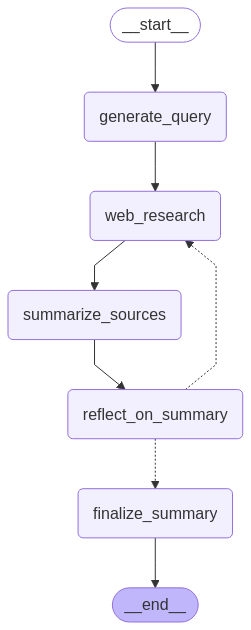

In [7]:
import json

from typing_extensions import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph

# from ollama_deep_researcher.configuration import Configuration, SearchAPI
# from ollama_deep_researcher.utils import deduplicate_and_format_sources, tavily_search, format_sources, perplexity_search, duckduckgo_search, searxng_search, strip_thinking_tokens, get_config_value
# from ollama_deep_researcher.state import SummaryState, SummaryStateInput, SummaryStateOutput
# from ollama_deep_researcher.prompts import query_writer_instructions, summarizer_instructions, reflection_instructions, get_current_date
# from ollama_deep_researcher.lmstudio import ChatLMStudio

# Nodes
def generate_query(state: SummaryState, config: RunnableConfig):
    """LangGraph node that generates a search query based on the research topic.
    
    Uses an LLM to create an optimized search query for web research based on
    the user's research topic. Supports both LMStudio and Ollama as LLM providers.
    
    Args:
        state: Current graph state containing the research topic
        config: Configuration for the runnable, including LLM provider settings
        
    Returns:
        Dictionary with state update, including search_query key containing the generated query
    """
    print("---------<Generate Queries>--------------")
    # Format the prompt
    current_date = get_current_date()
    formatted_prompt = query_writer_instructions.format(
        current_date=current_date,
        research_topic=state.research_topic
    )

    # Generate a query
    configurable = Configuration.from_runnable_config(config)
    
    # Choose the appropriate LLM based on the provider
    llm_json_mode = ChatOllama(
        base_url=configurable.ollama_base_url, 
        model=configurable.local_llm, 
        temperature=0, 
        format="json"
        )
    
    result = llm_json_mode.invoke(
        [SystemMessage(content=formatted_prompt),
        HumanMessage(content=f"Generate a query for web search:")]
    )
    
    # Get the content
    content = result.content

    # Parse the JSON response and get the query
    try:
        query = json.loads(content)
        search_query = query['query']
    except (json.JSONDecodeError, KeyError):
        # If parsing fails or the key is not found, use a fallback query
        if configurable.strip_thinking_tokens:
            content = strip_thinking_tokens(content)
        search_query = content
    print(f">>> Search Query: {search_query}")
    return {"search_query": search_query}

def web_research(state: SummaryState, config: RunnableConfig):
    """LangGraph node that performs web research using the generated search query.
    
    Executes a web search using the configured search API (tavily, perplexity, 
    duckduckgo, or searxng) and formats the results for further processing.
    
    Args:
        state: Current graph state containing the search query and research loop count
        config: Configuration for the runnable, including search API settings
        
    Returns:
        Dictionary with state update, including sources_gathered, research_loop_count, and web_research_results
    """
    print("---------<Web Research>--------------")
    # Configure
    configurable = Configuration.from_runnable_config(config)

    # Get the search API
    search_api = get_config_value(configurable.search_api)

    # Search the web
    if search_api == "tavily":
        search_results = tavily_search(state.search_query, fetch_full_page=configurable.fetch_full_page, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, fetch_full_page=configurable.fetch_full_page)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")
    
    print(f">>> web_research_results: {search_str}")
    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

def summarize_sources(state: SummaryState, config: RunnableConfig):
    """LangGraph node that summarizes web research results.
    
    Uses an LLM to create or update a running summary based on the newest web research 
    results, integrating them with any existing summary.
    
    Args:
        state: Current graph state containing research topic, running summary,
              and web research results
        config: Configuration for the runnable, including LLM provider settings
        
    Returns:
        Dictionary with state update, including running_summary key containing the updated summary
    """
    print("---------<Summarize Sources>--------------")
    # Existing summary
    existing_summary = state.running_summary

    # Most recent web research
    most_recent_web_research = state.web_research_results[-1]

    # Build the human message
    if existing_summary:
        human_message_content = (
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Context> \n {most_recent_web_research} \n <New Context>"
            f"Update the Existing Summary with the New Context on this topic: \n <User Input> \n {state.research_topic} \n <User Input>\n\n"
        )
    else:
        human_message_content = (
            f"<Context> \n {most_recent_web_research} \n <Context>"
            f"Create a Summary using the Context on this topic: \n <User Input> \n {state.research_topic} \n <User Input>\n\n"
        )

    # Run the LLM
    configurable = Configuration.from_runnable_config(config)
    
    # Choose the appropriate LLM based on the provider
    llm = ChatOllama(
        base_url=configurable.ollama_base_url, 
        model=configurable.local_llm, 
        temperature=0
        )
    
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions),
        HumanMessage(content=human_message_content)]
    )

    # Strip thinking tokens if configured
    running_summary = result.content
    if configurable.strip_thinking_tokens:
        running_summary = strip_thinking_tokens(running_summary)

    print(f">>> running_summary: {running_summary}")
    return {"running_summary": running_summary}

def reflect_on_summary(state: SummaryState, config: RunnableConfig):
    """LangGraph node that identifies knowledge gaps and generates follow-up queries.
    
    Analyzes the current summary to identify areas for further research and generates
    a new search query to address those gaps. Uses structured output to extract
    the follow-up query in JSON format.
    
    Args:
        state: Current graph state containing the running summary and research topic
        config: Configuration for the runnable, including LLM provider settings
        
    Returns:
        Dictionary with state update, including search_query key containing the generated follow-up query
    """
    print("---------<Reflect on Summary>--------------")
    # Generate a query
    configurable = Configuration.from_runnable_config(config)
    
    # Choose the appropriate LLM based on the provider
    llm_json_mode = ChatOllama(
        base_url=configurable.ollama_base_url, 
        model=configurable.local_llm, 
        temperature=0, 
        format="json"
        )
    
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Reflect on our existing knowledge: \n === \n {state.running_summary}, \n === \n And now identify a knowledge gap and generate a follow-up web search query:")]
    )
    
    # Strip thinking tokens if configured
    try:
        # Try to parse as JSON first
        reflection_content = json.loads(result.content)
        # Get the follow-up query
        query = reflection_content.get('follow_up_query')
        # Check if query is None or empty
        if not query:
            # Use a fallback query
            return {"search_query": f"Tell me more about {state.research_topic}"}
        print(f">>> Not Query_search_query: {query}")
        return {"search_query": query}
    except (json.JSONDecodeError, KeyError, AttributeError):
        # If parsing fails or the key is not found, use a fallback query
        print(f"Tell me more about {state.research_topic}")
        return {"search_query": f"Tell me more about {state.research_topic}"}
        
def finalize_summary(state: SummaryState):
    """LangGraph node that finalizes the research summary.
    
    Prepares the final output by deduplicating and formatting sources, then
    combining them with the running summary to create a well-structured
    research report with proper citations.
    
    Args:
        state: Current graph state containing the running summary and sources gathered
        
    Returns:
        Dictionary with state update, including running_summary key containing the formatted final summary with sources
    """
    print("---------<Finalize Summary>--------------")
    # Deduplicate sources before joining
    seen_sources = set()
    unique_sources = []
    
    for source in state.sources_gathered:
        # Split the source into lines and process each individually
        for line in source.split('\n'):
            # Only process non-empty lines
            if line.strip() and line not in seen_sources:
                seen_sources.add(line)
                unique_sources.append(line)
    
    # Join the deduplicated sources
    all_sources = "\n".join(unique_sources)
    state.running_summary = f"## Summary\n{state.running_summary}\n\n ### Sources:\n{all_sources}"
    print(f">>> running_summary: {state.running_summary}")
    return {"running_summary": state.running_summary}

def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """LangGraph routing function that determines the next step in the research flow.
    
    Controls the research loop by deciding whether to continue gathering information
    or to finalize the summary based on the configured maximum number of research loops.
    
    Args:
        state: Current graph state containing the research loop count
        config: Configuration for the runnable, including max_web_research_loops setting
        
    Returns:
        String literal indicating the next node to visit ("web_research" or "finalize_summary")
    """
    print("---------<Route Research>--------------")
    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        print(">>>Routing to web research")
        return "web_research"
    else:
        print(">>> Routing to web finalize_summary")
        return "finalize_summary"

# Add nodes and edges
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput, config_schema=Configuration)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)

# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research)
builder.add_edge("finalize_summary", END)

graph = builder.compile()
graph

# Test

In [9]:
# Run
import pprint

inputs = {"research_topic": "최근 한화오션 기업 동향"}
for output in graph.stream(input=inputs):
    # print(output)
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
# pprint.pprint(value['keys']['documents'])
pprint.pprint(value['keys']['generation'])

---------<Generate Queries>--------------
>>> Search Query: 한화오션 기업 동향 2025
Node 'generate_query':
'\n---\n'
---------<Web Research>--------------
>>> web_research_results: Sources:

Source: 한화오션 주가 분석 2025: 기업개요부터 재무·투자지표까지 완벽 정리
===
URL: https://jung-defi.tistory.com/entry/한화오션-주가-분석-2025-기업개요부터-재무·투자지표까지-완벽-정리
===
Most relevant content from source: 외국인 투자자 지분율: 약 2530% (2025년 2월 기준 7,500만~9,000만 주 추정). ▶ CB(전환사채) 영향: 2023년 발행 2.3조 원 규모 CB(전환가 4만 350원)가 주가 74,300원으로 상승하며 전환 가속화 가능성. ▶ 외국인 순매수: 2025년 2월 순매수 2위(1,185억 원) 기록 후 3월 추가 매수로 주가 급등 견인. ▶ 매출액: 약 10조 7,000억 원 (+45%). ▶ 수주 모멘텀: 2024년 카타르 LNG선 12척(약 33억 달러) 포함 누적 수주액 증가. ▶ 외부 환경: 환율 상승(1,350원/USD 추정), 글로벌 친환경 선박 수요 증가, 미국 방산 시장 진출이 가치 상승 촉진. ▶ 리스크: 단기 주가 과열(2025년 1월 50% 상승 후 조정 가능성), CB(전환사채) 2.3조 원 물량(전환가 4만 350원) 전환 시 주식 희석 우려. ▶ PER: 2023년: 33.15배. 단기 (20일): 2025년 1월 6일 이평선 타고 가파른 상승(5만 1,000원 기록).
===
Full source content limited to 1000 tokens: Published Time: 2025-03-03T18:13:04+09:00
한화오션 주가 분석 2025: 기업개요부터 재무·투자지표까지 완벽 정리


KeyError: 'keys'

In [ ]:
from IPython.display import Markdown
Markdown(value['keys']['generation'])